In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyaldata
import h5py

from numpy.fft import fft, fftfreq

# %load_ext lab_black

In [56]:

# just going to hard code this obviously change this if the data changes
experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat",  # the best!
    # "Chewie_CO_VR_2016-09-09.mat",
    # "Chewie_CO_VR_2016-09-12.mat",
    # "Chewie_CO_VR_2016-09-14.mat",
    # "Chewie_CO_VR_2016-10-06.mat",
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
    # "Mihili_CO_VR_2014-03-03.mat",
    # "Mihili_CO_VR_2014-03-04.mat",
    # "Mihili_CO_VR_2014-03-06.mat",
]


# Helpers (mainly plotting)

In [3]:
def plot_neuron_n_info(n, spike_data, AD_start, WO_start, vel, time_ticks, sort_trials, area, before_align_point=100):
    """
    This shouldnt be a helper tbh but needed to plot many neurons so now here we are
    n : neuron id to plot (relative to spike data) 
    spike_data : aligned spikes
    AD_start : idx of row in df with first AD trial
    WO_start : idx of row in df with first WO tria 
    vel : hand velocity (aligned as with spike data) 
    time_ticks : used throughout for plotting
    sort_trials : 
    area : name of region (M1/PMd/all) used for plot title
    before_align_point=100 : first part of window size
    """

    # n = 27 # [14, 27, 29, 35, 50, 58, 61, 64, 66, 69]
    #sort_trials = np.argsort(target_on)

    fig = plt.figure(figsize=(5, 10))
    ax1 = fig.add_subplot(311)

    kernel = np.exp(-np.linspace(-3,3,20)**2)
    kernel /= kernel.sum()

    for e,fr in zip(['BL',"AD",'WO'],[spike_data[:AD_start].mean(0),spike_data[AD_start:WO_start].mean(0),spike_data[WO_start:].mean(0)]):
        fr_s = np.asarray([np.convolve(np.concatenate([fr[::-1,i],fr[:,i],fr[::-1,i]]), kernel, mode='same')[fr.shape[0]:-fr.shape[0]] for i in range(fr.shape[1])]).T
        plt.plot(fr_s[:,n],label=f'avg. fr in {e}')

    for e,c,v in zip(['BL','AD','W0'],['C0','C1','C2'],[vel[:AD_start].mean(0),vel[AD_start:WO_start].mean(0),vel[WO_start:].mean(0)]):
        plt.plot(-v[:,0]/50,c=c,linestyle="--",label=f'avg. vel X in {e}')

    plt.axvline(before_align_point, color='red', linestyle='-', label='peak speed')
    plt.legend(loc='upper left')
    plt.title(f'Firing rate of {area} neuron #{n}, avg. per epoch')
    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.xlabel('time (ms)')
    plt.ylabel('neuron #')


    fig.add_subplot(312,sharex=ax1)
    plt.axvline(before_align_point, color='red', linestyle='-', label='go cue')

    # plt.scatter(before_align_point - target_on[sort_trials], np.arange(len(target_on)), color='red', label='target on',marker='|')
    plt.imshow(spike_data[sort_trials,:,n], aspect='auto', cmap='gray_r',interpolation='none')
    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.title(f'Example {area} neuron #{n}')
    plt.xlabel('time (ms)')
    plt.ylabel('trial #')

    plt.axhline(AD_start, color='blue', linestyle='-', label='AD')
    plt.axhline(WO_start, color='blue', linestyle='-', label='WO')

    fig.add_subplot(313,sharex=ax1)
    plt.axvline(before_align_point, color='red', linestyle='-', label='go cue')

    plt.imshow(vel[...,0],aspect='auto', cmap='gray',interpolation='none')
    plt.axhline(AD_start, color='blue', linestyle='-', label='AD')
    plt.axhline(WO_start, color='blue', linestyle='-', label='WO')

    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.title(f'Velocity X')
    plt.xlabel('time (ms)')
    plt.ylabel('trial #')

    plt.tight_layout(h_pad=1)

# Set paths

In [4]:
raw_data_dir = (
    "/disk/scratch2/nkudryas/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

# Set parameters

In [87]:
spike_data_dir = experiments[0] # which experiment from list above do you want to load

"""
activity_key : which neurons to load {"PMd_spikes", "M1_spikes", "all_spikes"}
behaviour_key : behaviour to train to (sometimes assumed to be velocity)
full_behaviour_key : the other behaviour (vel or pos). Here often assumed to be position
alignment : align trials to this point in the experinment. {"go"}
"""
activity_key = "all_spikes" #"PMd_spikes" # "all_spikes" #"M1_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation
full_behaviour_key = "pos"  # extra variable used for validation

"""
perc_train : percentage of trials to use for training
perc_valid/test : percentage of trials to use for valid/test sets. In some code if perc_test==0 then test set will be equivalent to valid set (stops lfads complaining)
"""
perc_train = 80
perc_valid = 20
perc_test = 0

"""
start_key : point to align trials to
shortest_trial : length of trials once aligned (in bins, 10ms assumed)
before_align_point : time to keep before alignment point (in bins, 10ms assumed)
"""
start_key = "idx_go_cue" #'idx_peak_speed' # 
before_align_point = 100 

"""
dataset_type : keep all epochs? session is all epochs, can also do BLAD (only baseline and adaptation trials)
"""
dataset_type = "session"

longest_trial = None # dont know

ablation_study=True
oscillation_threshold = 0.6 # doesnt matter (except plotting) unless ablation_study==True

"""
dt : time step size - this actually depends on the bin window but I cant find where this is set - it is 10ms rn
"""
dt = 0.01

# Fourier

time_window_start = 80 # this is the time point to start the window for the FFT (())d[start_key] - before_align_point : d[start_key] + shortest_trial



In [88]:
# load data
pd_data = pyaldata.io.mat2dataframe(
    path=raw_data_dir + spike_data_dir, shift_idx_fields=True
)
if activity_key == "all_spikes":
    pd_data[activity_key] = [
        np.concatenate([m1, pmd], axis=1)
        for m1, pmd in zip(pd_data["M1_spikes"], pd_data["PMd_spikes"])
    ]
    print(
        pd_data["M1_spikes"][0].shape,
        pd_data["PMd_spikes"][0].shape,
        pd_data["all_spikes"][0].shape,
    )

num_m1_units = pd_data["M1_spikes"][0].shape[1]

# sanity check train/valid/test settings
assert perc_train + perc_valid + perc_test == 100

# needed for plots, must align with chosen region
activity_key_to_area = {"PMd_spikes" : "PMd", "M1_spikes" : "M1", "all_spikes" : "all"}
area = activity_key_to_area[activity_key] # 'M1' #'PMd' # 'all' # 'M1'

# trials must be successful to be included
selected_trials = pd_data.loc[
        (pd_data.result == "R") #& (pd_data.epoch == "AD")
    ]

shortest_trial = int(
        (selected_trials.idx_trial_end - selected_trials[start_key]).min()
    )
print(start_key,shortest_trial)

# spike data from area, aligned to start key such that with window [- before_align_point : start_key : + shortest trial ]
spike_data = np.asarray(
        [
            d[f'{area}_spikes'][d[start_key] - before_align_point : d[start_key] + shortest_trial, :]
            for i, d in selected_trials.iterrows()
        ]
    )
print(spike_data.shape)
# time between start key and go cue
target_on = np.asarray(
        [
            d[start_key] - d['idx_go_cue']
            for i, d in selected_trials.iterrows()
        ]
    )
# epoch (BL/AD/WO) for each trial
epoch = np.asarray(
        [
            d['epoch']
            for i, d in selected_trials.iterrows()
        ]
    )
# trial types are ordered in df
AD_start = np.where(epoch=='AD')[0][0]
WO_start = np.where(epoch=='WO')[0][0]

# velocity of hand, aligned to start key as above
vel = np.asarray(
        [
            d['vel'][d[start_key] - before_align_point : d[start_key] + shortest_trial]
            for i, d in selected_trials.iterrows()
        ]
    )

# useful for plotting
time_ticks = np.arange(spike_data.shape[1])[::25]
sort_trials = np.arange(len(target_on))

(388, 76) (388, 233) (388, 309)
idx_go_cue 102
(707, 202, 309)


In [89]:
spike_data.shape # 581 total trials, 155 time points (before_align_point + shortest_trial), 207 neurons for full set

(707, 202, 309)

In [90]:
FR = np.zeros_like(spike_data,dtype='float')
kernel = np.exp(-np.linspace(-3,3,12)**2)
kernel /= np.sum(kernel)
# plt.plot(kernel)
for t in range(spike_data.shape[0]):
    for n in range(spike_data.shape[2]):
        # spikes = np.zeros(FR.shape[1])
        spikes = spike_data[t,:,n]
        FR[t,:,n] = np.convolve(spikes, kernel, mode='same')

In [91]:

power5_shuffled = []
for _ in range(100):
    shuffled_spikes = np.zeros_like(spike_data)
    for t in range(spike_data.shape[0]):
        for n in range(spike_data.shape[2]):
            shuffled_spikes[t,:,n] = np.random.permutation(spike_data[t,:,n])

    fr = shuffled_spikes[AD_start:WO_start, time_window_start:] # get data for AD trials, time point 80 onwards
    T = dt * fr.shape[1]

    power5 = []
    for i in range(fr.shape[-1]): # for each neuron
        x = fr[:, :, i] # get the AD spike data for neuron i

        xf = fft(x)  # Compute Fourier transform of x
        Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum
        Sxx = np.nanmean(Sxx, axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = np.argmin(np.abs(faxis - 5))
        power5.append(Sxx.real[j]/(Sxx.real[j-1]+Sxx.real[j+1])) # power at 5Hz

    power5_shuffled.append(power5)
power5_shuffled = np.asarray(power5_shuffled)

In [92]:
faxis[j]

4.918032786885246

13
66


(0.0, 0.01)

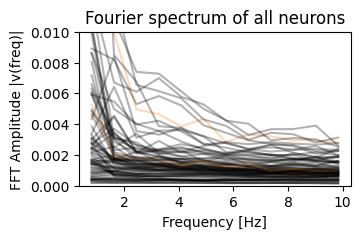

In [95]:

plt.figure(figsize=(3.5,2))

fr = spike_data[AD_start:WO_start, time_window_start:] # get data for AD trials, time point 80 onwards
T = dt * fr.shape[1]

power5 = []
for i in range(fr.shape[-1]): # for each neuron
    # if i==0:
    x = fr[:, :, i] # get the AD spike data for neuron i

    xf = fft(x)  # Compute Fourier transform of x
    Sxx_all = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum

    power5_cv = []
    for cv in range(10):
        idxs = np.random.choice(np.arange(Sxx_all.shape[0]),int(0.8*Sxx_all.shape[0]),replace=False)
        Sxx = np.nanmean(Sxx_all[idxs], axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = np.argmin(np.abs(faxis - 5))
        power5_cv.append(Sxx.real[j]/(Sxx.real[j-1]+Sxx.real[j+1]))

    power5.append(np.mean(power5_cv)) # power at 5Hz

    SR = Sxx.real

    if (activity_key=="all_spikes") and (i<=pd_data["M1_spikes"][0].shape[1]):
        # only plot if m1
        thr = power5_shuffled[:,i].mean() + 2 * power5_shuffled[:,i].std()
        if power5[-1]>=thr:
            print(i)
        plt.plot(
            faxis[(faxis > 0) & (faxis <= 10)],
            SR[(faxis > 0) & (faxis <= 10)],c='k' if power5[-1]<thr else 'C1',alpha=0.3)
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT Amplitude |v(freq)|')
plt.title(f'Fourier spectrum of {area} neurons')
plt.ylim([0.0,0.01])

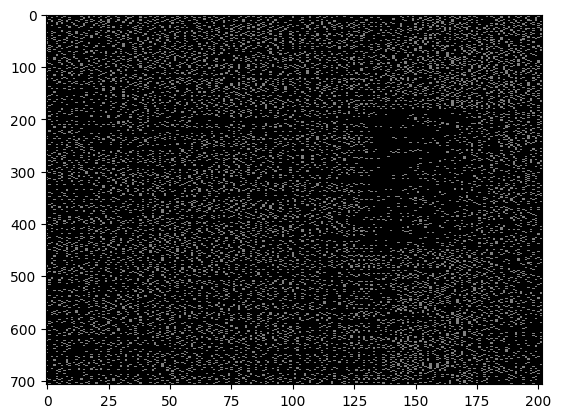

In [97]:
plt.imshow(spike_data[:,:,66],aspect='auto',cmap='gray',interpolation='none')

---

# Create two sets - subsampling neurons according to oscillating/non-oscillating.

In [34]:
# identify neurons which are oscillating based on the power5 array

print(oscillation_threshold)
# n_m1 = 70 # number of m1 neurons in the set we are only going to care about m1 neurons oscillating
# n_total = 207

total_neurons = len(power5)
oscillating_criteria = np.where(np.array(power5)>oscillation_threshold)[0]
oscillating_neurons = [x for x in oscillating_criteria if x<=num_m1_units] # idx for oscillating neurons
# non_oscillating_neurons = np.where(np.array(power5)<=oscillation_threshold)[0] # since there are nans caused by the fourier transform, just take anything not flagged as oscillating
non_oscillating_neurons = [x for x in np.arange(0,207) if (x not in oscillating_neurons)]
if ablation_study:


    # calculate number of train and test neurons
    # neurons_per_set = total_neurons - len(oscillating_neurons) # subsample neurons based on number of oscillating neurons


    # oscillation_control set contains neurons which oscillate
    # randomly subset neurons_per_set
    # np.random.seed(38) # dont change this
    # poss_array = sorted(np.random.choice(np.arange(0,70), neurons_per_set, replace=False))
    # # sneaky check that we kept all the oscillating neurons
    # len([x for x in poss_array if x in oscillating_neurons])==10

    # oscillation_ablation set contain neurons which do not oscillate

    neurons_to_keep = non_oscillating_neurons # dont ablate these
    print(oscillating_neurons)
    print(len(oscillating_neurons))
    # len(neurons_to_keep)
else:
    neurons_to_keep = np.arange(0, len(power5))


0.6
[14, 27, 29, 35, 50, 61, 64, 66, 69]
9


# check tuning of oscillating neurons

Shortest : 101, longest: 150, succesful trials: 581/662
(581, 25)


In [39]:

# aligned spike data - excludes neurons if ablation_study=True
all_spike_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, neurons_to_keep]
            for i, d in successful_trials.iterrows()
        ]
    )
print(all_spike_data.shape)

# target directions for each trial
target_directions = np.asarray([d["target_direction"] for i, d in successful_trials.iterrows()])
print(target_directions.shape)
# as above but index
set_directions = sorted(set(target_directions))
dir_index = np.array([set_directions.index(i) for i in target_directions])
print(len(dir_index))


(581, 101, 198)
(581,)
581


In [57]:
shortest_trial
# all_spike_data.shape[1]

101

In [40]:


trials_by_direction_dict = {i:all_spike_data[list(np.where(dir_index==i)[0]),:,:] for i in np.unique(dir_index)}
trial_inds_by_direction_dict = {i: np.where(dir_index==i)[0] for i in np.unique(dir_index)}


In [41]:
# fr = spike_data[:AD_start, 100:]

def get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start):

    pow5_dict = {}
    for dir_ind, trial_inds in trial_inds_by_direction_dict.items():
        trial_inds_AD = [tr for tr in trial_inds if tr>=AD_start and tr<WO_start] # get adaptation trials for condition
        fr = spike_data[trial_inds_AD, 80:, neuron] # get data for AD trials, time point 80 onwards
        # print(fr.shape)

        T = dt * fr.shape[1]

        # power5 = []
        # for i in range(fr.shape[-1]): # for each neuron
        # if i==0:
        x = fr # get the AD spike data for neuron i

        # x = (x - x.mean(0)) / x.std(0) # z score by mean over trials for each timepoint

        xf = fft(x)  # Compute Fourier transform of x
        Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum
        Sxx = np.nanmean(Sxx, axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = 4 # timepoint of interest...?
        # print(faxis[j],Sxx.real[j])
        # print(Sxx.real[j-1], Sxx.real[j], Sxx.real[j+1])
        pow_entry = (Sxx.real[j]/(Sxx.real[j-1]+Sxx.real[j+1]))
        if np.isnan(pow_entry):
            pow_entry = 0
        pow5_dict[dir_ind] = pow_entry # power at 5Hz

        # SR = Sxx.real
        # SR[SR>0.05] = 0.05
    return pow5_dict

In [42]:
get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, 1, AD_start, WO_start)

{0: 0.4478790022161483,
 1: 0.5821118143305857,
 2: 0.46773132048744687,
 3: 0.41669699546982464,
 4: 0.4893193998861409,
 5: 0.6022771231540662,
 6: 0.6366413292987431,
 7: 0.826474654304439}

In [43]:
# this_trial_type = trials_by_direction_dict[0]
# neuron = 0

def plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions):
    # dict of {cond_index : power} pairs

    avg_activity_by_cond = []
    max_activity_by_cond = []

    for i, trials_for_dir in trials_by_direction_dict.items():
        trials_for_neuron = trials_for_dir[:,:before_align_point,neuron]
        avg_across_trials = np.nanmean(trials_for_neuron, axis=0) ##

        # average and max avg activity across trials of this type
        avg_across_time = avg_across_trials.mean()
        # print(avg_across_time)
        avg_activity_by_cond.append(avg_across_time)

        max_across_time = avg_across_trials.max()
        # print(max_across_time)
        max_activity_by_cond.append(max_across_time)

        # xax = np.arange(0, avg_across_trials.shape[0])
        # plt.plot(xax, avg_across_trials)

    pow5_by_cond = list(pow5_dict.values()) 

    # for i, dir in enumerate(set_directions):
    #     print(dir, avg_activity_by_cond[i], pow5_by_cond[i])

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    ax.plot(set_directions, avg_activity_by_cond, label='avg activity')
    ax.plot(set_directions, pow5_by_cond, label='power at 5Hz')

    ax.set_xlabel('Condition direction')
    ax.set_xticks(set_directions)
    ax.set_ylabel('Power at 5Hz within condition')
    ax.set_title(f'by condition, neuron {neuron}')
    ax.legend(loc='upper left')
    # ax[0].set_ylim([0.0,0.05])

    


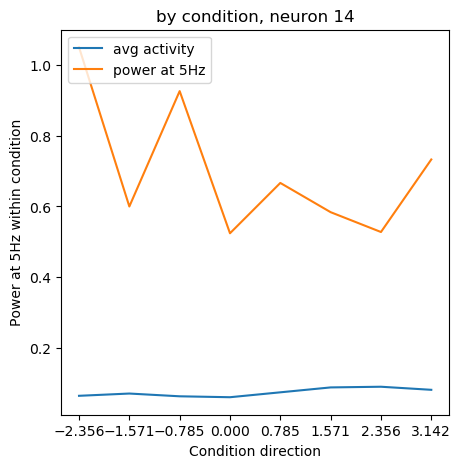

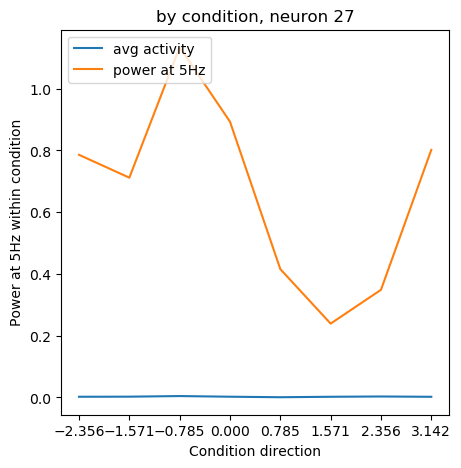

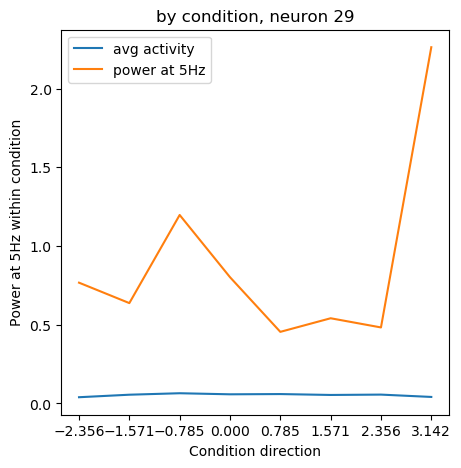

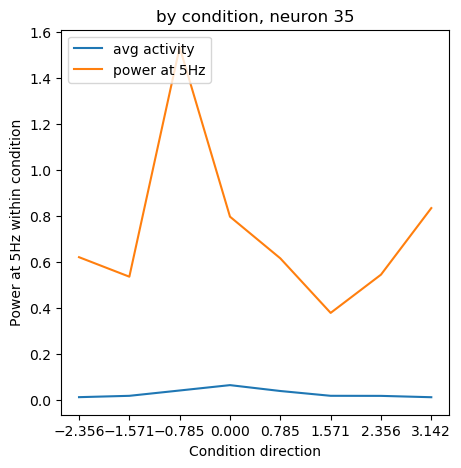

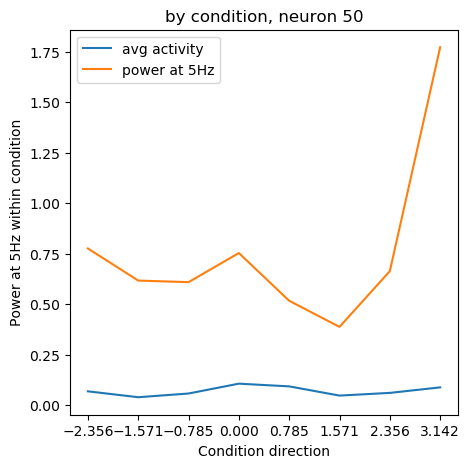

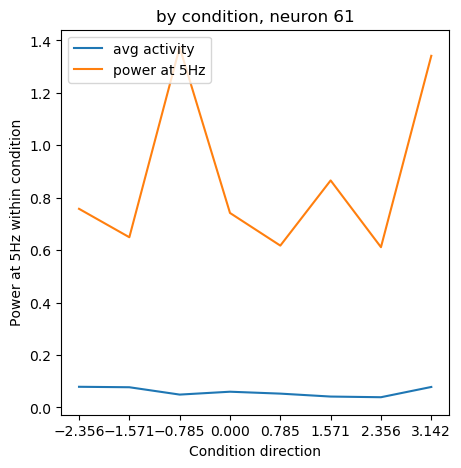

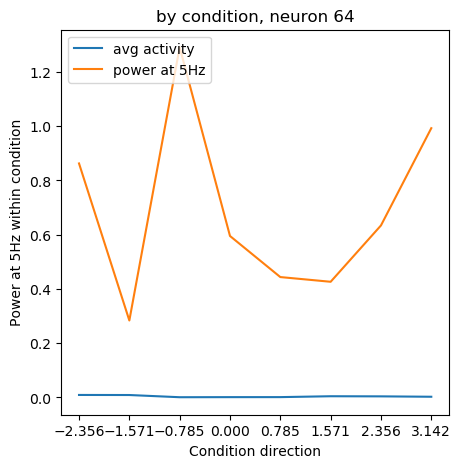

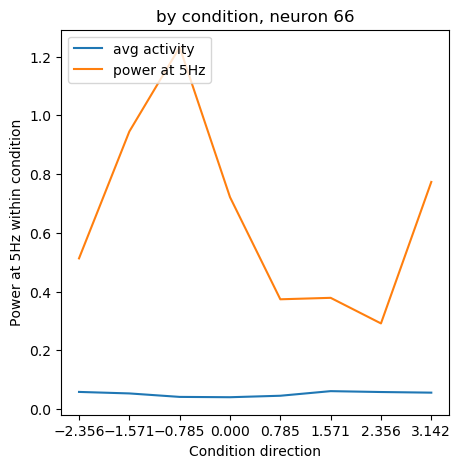

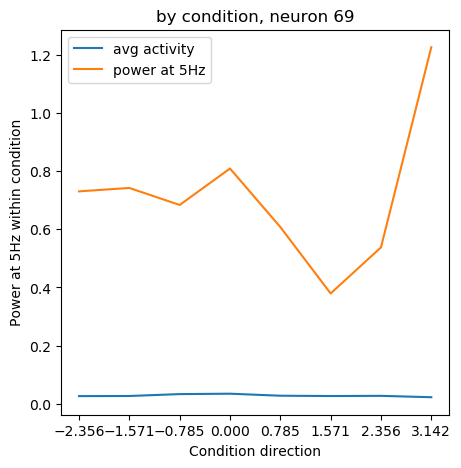

In [44]:
# neuron = 0

for neuron in oscillating_neurons:
    pow5_dict = get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start)
    plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions)